In [93]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import psycopg2
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
load_dotenv()
database_url = os.getenv("DATABASE_URL")
user = os.getenv("USER")
password = os.getenv("PASSWORD")

In [95]:
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def convert_bytes(nbytes):
    i=0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes/=1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i]) 

In [96]:
def data_processing(query):
    engine = create_engine(database_url)
    conn = engine.connect().execution_options(stream_results=True)

    chunks = []
    total_mem = 0
    i = 1

    for chunk_df in pd.read_sql_query(query, conn, chunksize=500000):
        print(f"Chunk {i} - rows: {len(chunk_df)}")
        total_mem += chunk_df.memory_usage(index=True, deep=True).sum()
        print(f" Memory usage: {chunk_df.memory_usage(deep=True).sum()/1024}")
        print(f"sys.getsizeof {sys.getsizeof(chunk_df)/1024}" )
        print(f" sys.getsizeof : {convert_bytes(chunk_df.memory_usage(index=True, deep=True).sum())}")
        chunks.append(chunk_df)
        i+=1

    df = pd.concat(chunks, ignore_index=True)
    print(f"\n✅ Données chargées : {df.shape}")
    print(f"📊 Mémoire totale estimée : {convert_bytes(total_mem)}")

    return df


def show_most_na_col(df):
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']

    #Filtrer les 20 premières colonnes avec le plus de Nan

    top_missing = missing_df.head(20)

    #Affichage avec seaborn
    plt.figure(figsize=(12,6))
    sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis")

    plt.title("Top 20 colonnes avec le plus de valeurs manquantes")
    plt.xlabel("Pourcentage de valeurs manquantes(%)")
    plt.ylabel("Colonnes")
    plt.tight_layout()
    plt.show
def show_least_na_col(df):
    
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']
    least_missing = missing_df.tail(20)

    #Affichage avec seaborn
    plt.figure(figsize=(12,6))
    sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")

    plt.title("Top 20 colonnes avec le moins de valeurs manquantes")
    plt.xlabel("Pourcentage de valeurs manquantes(%)")
    plt.ylabel("Colonnes")
    plt.tight_layout()
    plt.show

def show_all_col_na(df):
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    missing_df = missing_percent.reset_index()
    missing_df.columns = ['column_name', 'missing_percentage']
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = [f"{i}–{i+10}%" for i in bins[:-1]]
    missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

    # Compte le nombre de colonnes dans chaque tranche
    bin_counts = missing_bins.value_counts().sort_index()

    # Affiche le histogramme
    plt.figure(figsize=(10, 6))
    sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
    plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
    plt.xlabel("Tranche de pourcentage de valeurs manquantes")
    plt.ylabel("Nombre de colonnes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# First analysis with NA on class_bilan_dpe (TABLE: batiment_groupe_dpe_representatif_logement)

In [97]:
query = """
        SELECT * 
        FROM table1 
        """

df = data_processing(query)

Chunk 1 - rows: 10000
 Memory usage: 62086.4208984375
sys.getsizeof 62086.4521484375
 sys.getsizeof : 60.63 MB

✅ Données chargées : (10000, 224)
📊 Mémoire totale estimée : 60.63 MB


In [98]:
display(df.head())

,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,numero_dpe_remplace,numero_dpe_immeuble_associe,id_rnb,numero_rpls_logement,...,description_generateur_froid,surface_climatisee,conso_refroidissement_annuel,categorie_enr,systeme_production_electricite_origine_renouvelable,presence_production_pv,surface_totale_capteurs_pv,nombre_module,production_electricite_pv_kwhep_par_an,electricite_pv_autoconsommee
0,2229E0488205H,2024-12-30,2022-03-08,2022-03-09,2022-03-10,2032-03-08,None,None,85EVGZ8WBSY7,None,...,None,NaN,NaN,None,None,NaN,NaN,NaN,0.0,NaN
1,2247E1057848I,2024-12-30,2022-05-11,2022-05-15,2022-05-16,2032-05-14,None,None,DFJBMET5XWBY,None,...,None,NaN,NaN,chauffage au bois,None,NaN,NaN,NaN,0.0,NaN
2,2275E0252200Y,2024-06-25,2022-02-02,2022-02-07,2022-02-08,2032-02-06,None,None,None,None,...,None,NaN,NaN,réseau de chaleur ou de froid vertueux,None,NaN,NaN,NaN,0.0,NaN
3,2233E0287314W,2024-12-12,2022-02-10,2022-02-11,2022-02-14,2032-02-10,None,None,34DQ9W3J8YPE,None,...,None,NaN,NaN,None,None,NaN,NaN,NaN,0.0,NaN
4,2269E0225484E,2024-12-30,2022-02-03,2022-02-03,2022-02-04,2032-02-02,None,None,2QQA8KQPM7JT,None,...,None,NaN,NaN,None,None,NaN,NaN,NaN,0.0,NaN


In [99]:
# Pourcentage de valeurs manquantes par colonne

missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

# # Affichage
# missing_df = pd.DataFrame({
#     'colonne': missing_percent.index,
#     'pourcentage_nan': missing_percent.values
# })

# #Afficher les colonnes et leur valeurs manquantes
# missing_df.head(40)

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\234471432.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis" )


<function matplotlib.pyplot.show(close=None, block=None)>

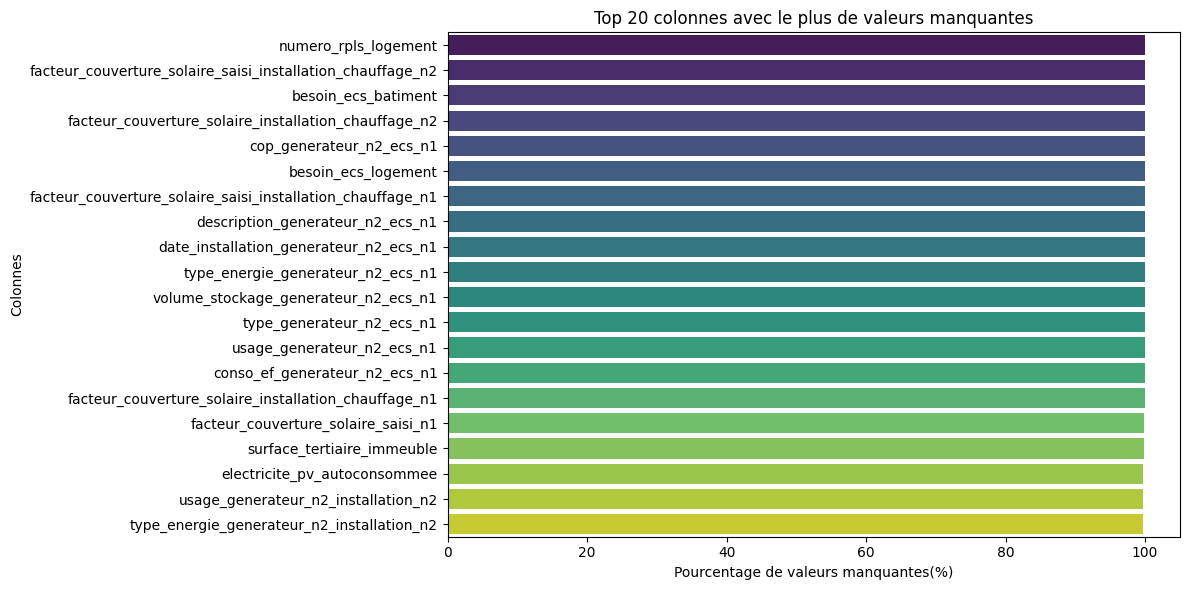

In [100]:
missing_df = missing_percent.reset_index()
missing_df.columns = ['column_name', 'missing_percentage']

#Filtrer les 20 premières colonnes avec le plus de Nan

top_missing = missing_df.head(20)

#Affichage avec seaborn
plt.figure(figsize=(12,6))
sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis" )

plt.title("Top 20 colonnes avec le plus de valeurs manquantes")
plt.xlabel("Pourcentage de valeurs manquantes(%)")
plt.ylabel("Colonnes")
plt.tight_layout()
plt.show

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\3590135676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")


<function matplotlib.pyplot.show(close=None, block=None)>

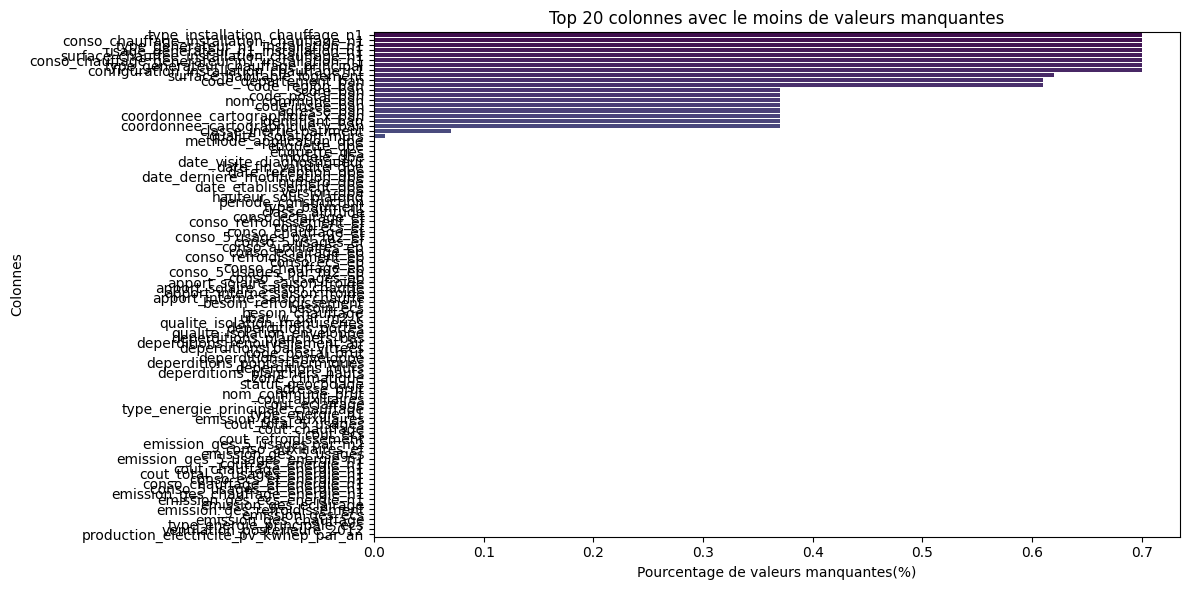

In [101]:
least_missing = missing_df.tail(100)

#Affichage avec seaborn
plt.figure(figsize=(12,6))
sns.barplot(x="missing_percentage", y="column_name", data= least_missing, palette="viridis")

plt.title("Top 20 colonnes avec le moins de valeurs manquantes")
plt.xlabel("Pourcentage de valeurs manquantes(%)")
plt.ylabel("Colonnes")
plt.tight_layout()
plt.show

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\677167116.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


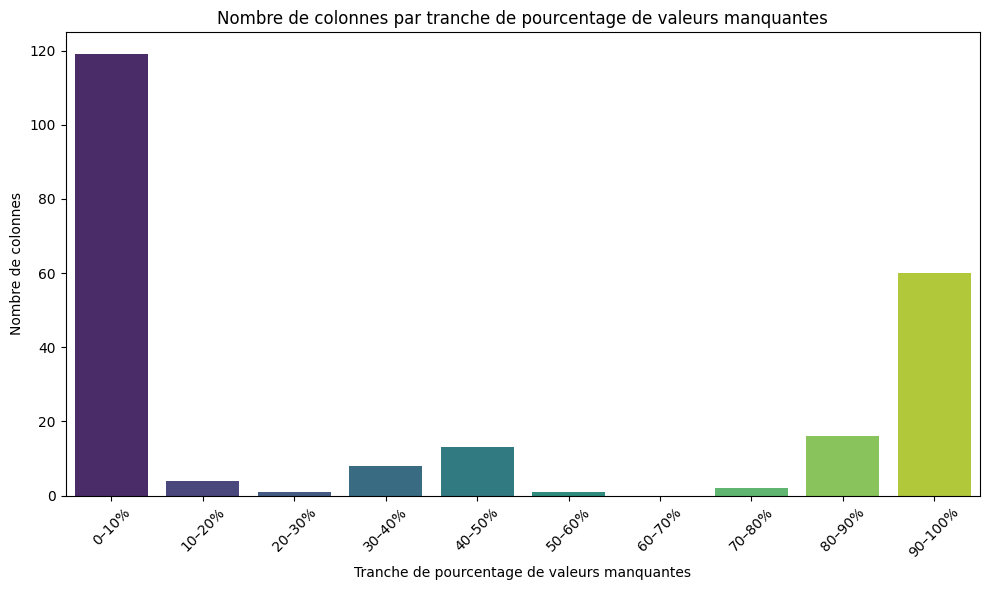

In [102]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [f"{i}–{i+10}%" for i in bins[:-1]]
missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

# Compte le nombre de colonnes dans chaque tranche
bin_counts = missing_bins.value_counts().sort_index()

# Affiche le histogramme
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
plt.xlabel("Tranche de pourcentage de valeurs manquantes")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### It would be good to see how many NA there is after suppression of every NA from target column

In [103]:
missing_NA_classe_dpe = df['etiquette_dpe'].isna().sum()

missing_NA_classe_dpe
# df_No_NA_class_dpe = 

np.int64(0)

Ok la table de base ici n'a pas de valeur manquante sur la variable cible. C'est bien

# Second analysis without na on class_bilan_dpe (TABLE: nona)

Chunk 1 - rows: 10000
 Memory usage: 62086.4208984375
sys.getsizeof 62086.4521484375
 sys.getsizeof : 60.63 MB

✅ Données chargées : (10000, 224)
📊 Mémoire totale estimée : 60.63 MB


C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\4269242654.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


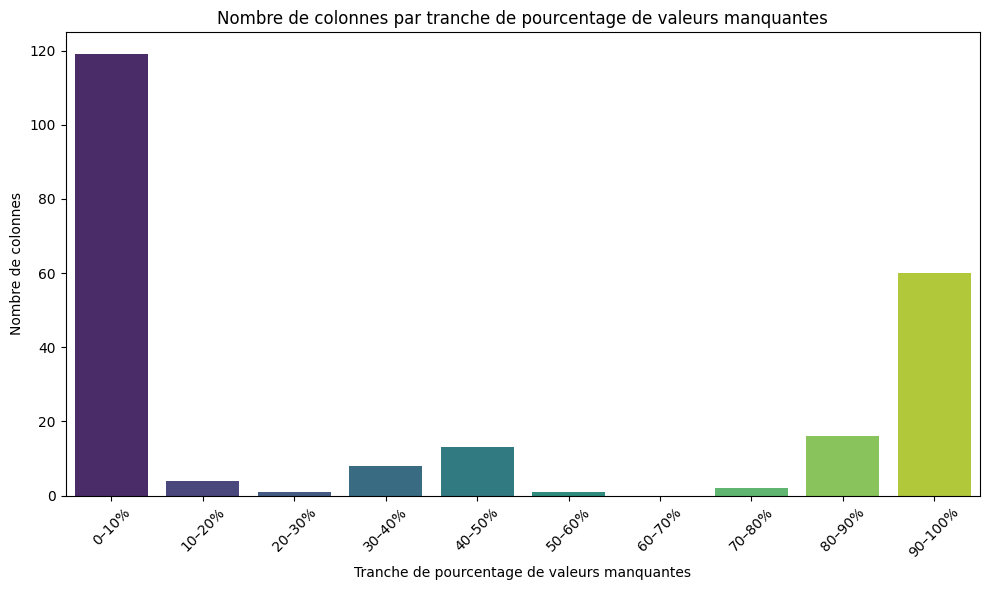

In [104]:
query2 = """
    SELECT *
    FROM table1
"""
df_nona = data_processing(query2)

missing_percent = df_nona.isnull().mean().sort_values(ascending=False) * 100

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [f"{i}–{i+10}%" for i in bins[:-1]]
missing_bins = pd.cut(missing_percent, bins=bins, labels=labels, include_lowest=True)

# Compte le nombre de colonnes dans chaque tranche
bin_counts = missing_bins.value_counts().sort_index()

# Affiche le histogramme
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")
plt.title("Nombre de colonnes par tranche de pourcentage de valeurs manquantes")
plt.xlabel("Tranche de pourcentage de valeurs manquantes")
plt.ylabel("Nombre de colonnes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [105]:
missing_df = missing_percent.reset_index(name = 'percent_missing')

columns_between_percent = missing_df[missing_df['percent_missing'].between(50,60)]
print(columns_between_percent)

                          index  percent_missing
78  complement_adresse_logement            54.93


Conclusion: We can first try to delete the col with NA above 50% without thinking too much because we have a lot of cols. 
The variable from 10 to 50 seem really interesting so we may try to replace missing values by mean later to improve model.
The variables with NA More than 50 don't seem to be interesting. 

Next step: create new table called table2 with only cols with NA less than 10%

In [106]:
threshold = 0.10
missing_ratio = df_nona.isna().mean()
df_filtered = df_nona.loc[:,missing_ratio < threshold]

print(f"✅ Colonnes supprimer : {df_nona.shape[1] - df_filtered.shape[1]}")

✅ Colonnes supprimer : 105


In [107]:
def place_sql_table(table_to_create_from_dataframe):
    engine = create_engine(database_url)
    table_to_create_from_dataframe.to_sql("table2", engine, index=False, if_exists="replace")
    print("✅ Table `table2` créée dans la base SQL.")

In [108]:
from sqlalchemy import create_engine
import pandas as pd

longueur_max =len(df_nona)


query = f"""
SELECT
  string_agg(
    format(
      'SUM(CASE WHEN %%I IS NULL THEN 1 ELSE 0 END)*100/{longueur_max} AS %%I',
      column_name, column_name
    ),
    ', '
  ) AS cols_expr
FROM information_schema.columns
WHERE table_schema = 'public'
  AND table_name   = 'table1'
"""

df_deux = data_processing(query)


Chunk 1 - rows: 1
 Memory usage: 24.3916015625
sys.getsizeof 24.4228515625
 sys.getsizeof : 24.39 KB

✅ Données chargées : (1, 1)
📊 Mémoire totale estimée : 24.39 KB


In [109]:
cols_expression = df_deux['cols_expr'].iloc[0]
print(df_deux)


                                           cols_expr
0  SUM(CASE WHEN numero_dpe IS NULL THEN 1 ELSE 0...


In [110]:
count_nulls_query = f"""
SELECT {cols_expression}
FROM table1
"""
null_counts_df  = data_processing(count_nulls_query)
display(null_counts_df )


Chunk 1 - rows: 1
 Memory usage: 1.87890625
sys.getsizeof 1.91015625
 sys.getsizeof : 1.88 KB

✅ Données chargées : (1, 224)
📊 Mémoire totale estimée : 1.88 KB


,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,numero_dpe_remplace,numero_dpe_immeuble_associe,id_rnb,numero_rpls_logement,...,description_generateur_froid,surface_climatisee,conso_refroidissement_annuel,categorie_enr,systeme_production_electricite_origine_renouvelable,presence_production_pv,surface_totale_capteurs_pv,nombre_module,production_electricite_pv_kwhep_par_an,electricite_pv_autoconsommee
0,0,0,0,0,0,0,91,96,43,100,...,92,92,92,78,91,91,99,99,0,99


Ok la c'est bien j'ai les nom des colonnes avec leur pourcentage de valeurs manquante
Ce que je fais mtn c'est recup le nom des cols avec un pourcentage de valeur manquante inférieur à 10%
ensuite je create a Table a partir de ces nom de variable et c'est bon!

In [111]:
missing_df = missing_percent.reset_index(name = 'percent_missing')

columns_between_percent_2 = missing_df[missing_df['index'] == "qualite_isolation_plancher bas"]
display(columns_between_percent_2)
print(len(df_nona))

,index,percent_missing
105,qualite_isolation_plancher bas,8.8


10000


In [112]:
null_counts_df.columns[143]

'type_emetteur_installation_chauffage_n1'

In [120]:
# query3 = ""

# for col in null_counts_df.columns:
#     if (null_counts_df[col][0] < 10):
#         if " " in col:
#             query3 += f'"{col}"' + ','
#         else:
#             query3 += col + ','

# print(query3[0:-1])
# query3 = query3[:-1]
# query = f"""CREATE TABLE table1_less_than_10p AS SELECT {query3} FROM table1;"""
engine = create_engine(database_url)
# with engine.begin() as connection:
#     connection.execute(text(query))

# Étape 2 : Lire les données de la table "clean"
df_clean = pd.read_sql("SELECT * FROM table1_less_than_10p", engine)

In [121]:
display(df_clean)

,numero_dpe,date_derniere_modification_dpe,date_visite_diagnostiqueur,date_etablissement_dpe,date_reception_dpe,date_fin_validite_dpe,modele_dpe,version_dpe,methode_application_dpe,etiquette_dpe,...,nombre_logements_desservis_par_installation_ecs_n1,surface_habitable_desservie_par_installation_ecs_n1,type_installation_solaire_n1,type_generateur_n1_ecs_n1,type_energie_generateur_n1_ecs_n1,usage_generateur_n1_ecs_n1,volume_stockage_generateur_n1_ecs_n1,conso_ef_generateur_n1_ecs_n1,ventilation_posterieure_2012,production_electricite_pv_kwhep_par_an
0,2229E0488205H,2024-12-30,2022-03-08,2022-03-09,2022-03-10,2032-03-08,DPE 3CL 2021 méthode logement,2.1,dpe appartement individuel,D,...,1.0,35.0,Non affecté,Chaudière gaz à condensation après 2015,Gaz naturel,chauffage + ecs,0.0,1276.1,0,0.0
1,2247E1057848I,2024-12-30,2022-05-11,2022-05-15,2022-05-16,2032-05-14,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,D,...,1.0,165.0,Non affecté,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,200.0,2275.6,0,0.0
2,2275E0252200Y,2024-06-25,2022-02-02,2022-02-07,2022-02-08,2032-02-06,DPE 3CL 2021 méthode logement,2.1,dpe appartement individuel,D,...,1.0,32.0,Non affecté,Réseau de chaleur isolé,Réseau de Chauffage urbain,chauffage + ecs,0.0,3670.8,0,0.0
3,2233E0287314W,2024-12-12,2022-02-10,2022-02-11,2022-02-14,2032-02-10,DPE 3CL 2021 méthode logement,2.1,dpe appartement individuel,G,...,1.0,38.0,Non affecté,Ballon électrique à accumulation horizontal,Électricité,ecs,100.0,1598.6,0,0.0
4,2269E0225484E,2024-12-30,2022-02-03,2022-02-03,2022-02-04,2032-02-02,DPE 3CL 2021 méthode logement,2.0,dpe appartement individuel,C,...,1.0,52.0,Non affecté,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,200.0,1933.6,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2295E0619126G,2024-02-06,2022-03-24,2022-03-24,2022-03-25,2032-03-23,DPE 3CL 2021 méthode logement,2.1,dpe maison individuelle,D,...,1.0,112.9,Non affecté,Chaudière gaz standard 2001-2015,Gaz naturel,chauffage + ecs,0.0,2142.7,0,0.0
9996,2241E0679600C,2024-02-06,2022-03-31,2022-03-31,2022-04-01,2032-03-30,DPE 3CL 2021 méthode logement,2.0,dpe maison individuelle,F,...,1.0,80.0,Non affecté,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,200.0,2035.1,0,0.0
9997,2278E0970868D,2024-02-06,2022-03-07,2022-05-04,2022-05-05,2032-05-03,DPE 3CL 2021 méthode logement,2.0,dpe maison individuelle,E,...,1.0,102.0,Non affecté,Ballon électrique à accumulation vertical Caté...,Électricité,ecs,200.0,2206.2,0,0.0
9998,2227E0492504O,2024-12-30,2022-02-22,2022-03-10,2022-03-11,2032-03-09,DPE 3CL 2021 méthode logement,2.1,dpe appartement individuel,F,...,1.0,92.0,Non affecté,Chauffe-eau gaz à production instantanée 1990-...,Gaz naturel,ecs,0.0,2105.5,0,0.0


## Step 3 (TABLE: table1_less_than_10p)

In [122]:
query2 = """
    SELECT *
    FROM table1_less_than_10p
"""
df_clean = data_processing(query2)

Chunk 1 - rows: 10000
 Memory usage: 40436.8154296875
sys.getsizeof 40436.8466796875
 sys.getsizeof : 39.49 MB

✅ Données chargées : (10000, 119)
📊 Mémoire totale estimée : 39.49 MB


C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\2104997485.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="missing_percentage", y="column_name", data= top_missing, palette="viridis")


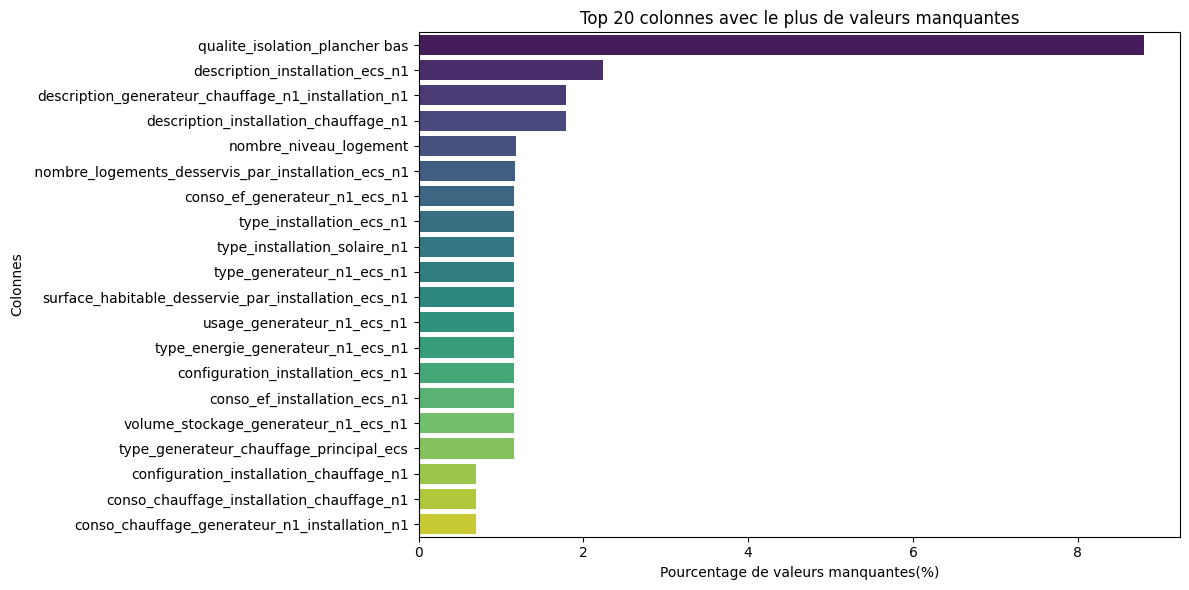

In [123]:
show_most_na_col(df_clean)

C:\Users\Adnane.BEN-ALI\AppData\Local\Temp\ipykernel_17676\2104997485.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="viridis")


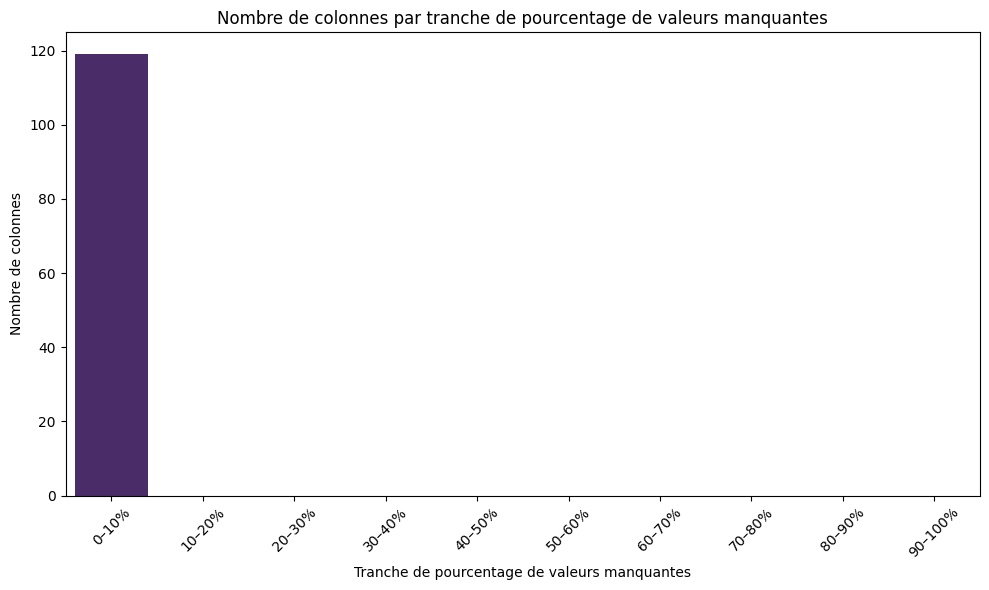

In [124]:
show_all_col_na(df_clean)

## Step 4: Voir les variables à faible variance et les supprimer

In [127]:
low_variance_info = []
df = df_clean

for col in df.columns:
    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
    n_unique = df[col].nunique(dropna=False)
    
    low_variance_info.append({
        "colonne": col,
        "top_freq_ratio (%)": round(top_freq * 100, 2),
        "nb_modalités": n_unique,
        "alerte_low_variance": top_freq >= 0.95
    })

low_variance_df = pd.DataFrame(low_variance_info)
low_variance_df = low_variance_df.sort_values("top_freq_ratio (%)", ascending=False)

cols_to_drop = low_variance_df[low_variance_df["top_freq_ratio (%)"] > 90]["colonne"].tolist()

# Affiche les colonnes avec +95% des valeurs identiques
print(low_variance_df.head(20))

                                               colonne  top_freq_ratio (%)  \
6                                           modele_dpe              100.00   
118             production_electricite_pv_kwhep_par_an               99.24   
111                       type_installation_solaire_n1               97.69   
117                       ventilation_posterieure_2012               97.25   
106                  configuration_installation_ecs_n1               96.58   
109   nombre_logements_desservis_par_installation_e...               94.45   
17                                     classe_altitude               93.38   
71                        emission_ges_refroidissement               92.91   
87                                cout_refroidissement               92.86   
57                            conso_refroidissement_ep               92.85   
64                            conso_refroidissement_ef               92.85   
52                        apport_solaire_saison_froide          

Pour l'instant on retire toutes les variables avec un top fréquence ratio supérieur a 90%. On pourra supprimer plus pour voir ensuite si ça améliore le modèle

In [128]:
df_cleaned = df.drop(columns=cols_to_drop)
print(f"✅ {len(cols_to_drop)} colonnes supprimées. Nouveau shape: {df_cleaned.shape}")

✅ 15 colonnes supprimées. Nouveau shape: (10000, 104)


## Step 5: Voir la corrélation entre 2 variables

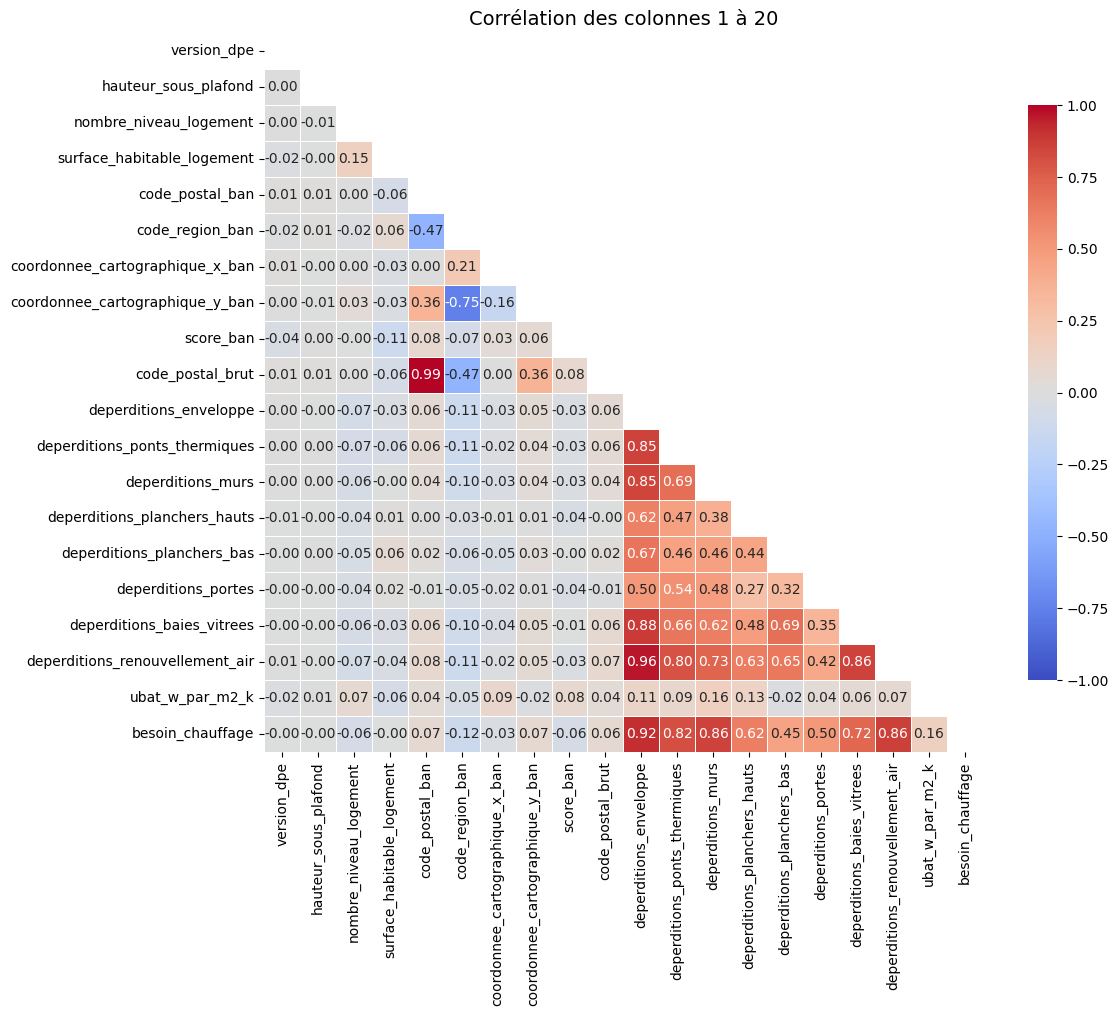

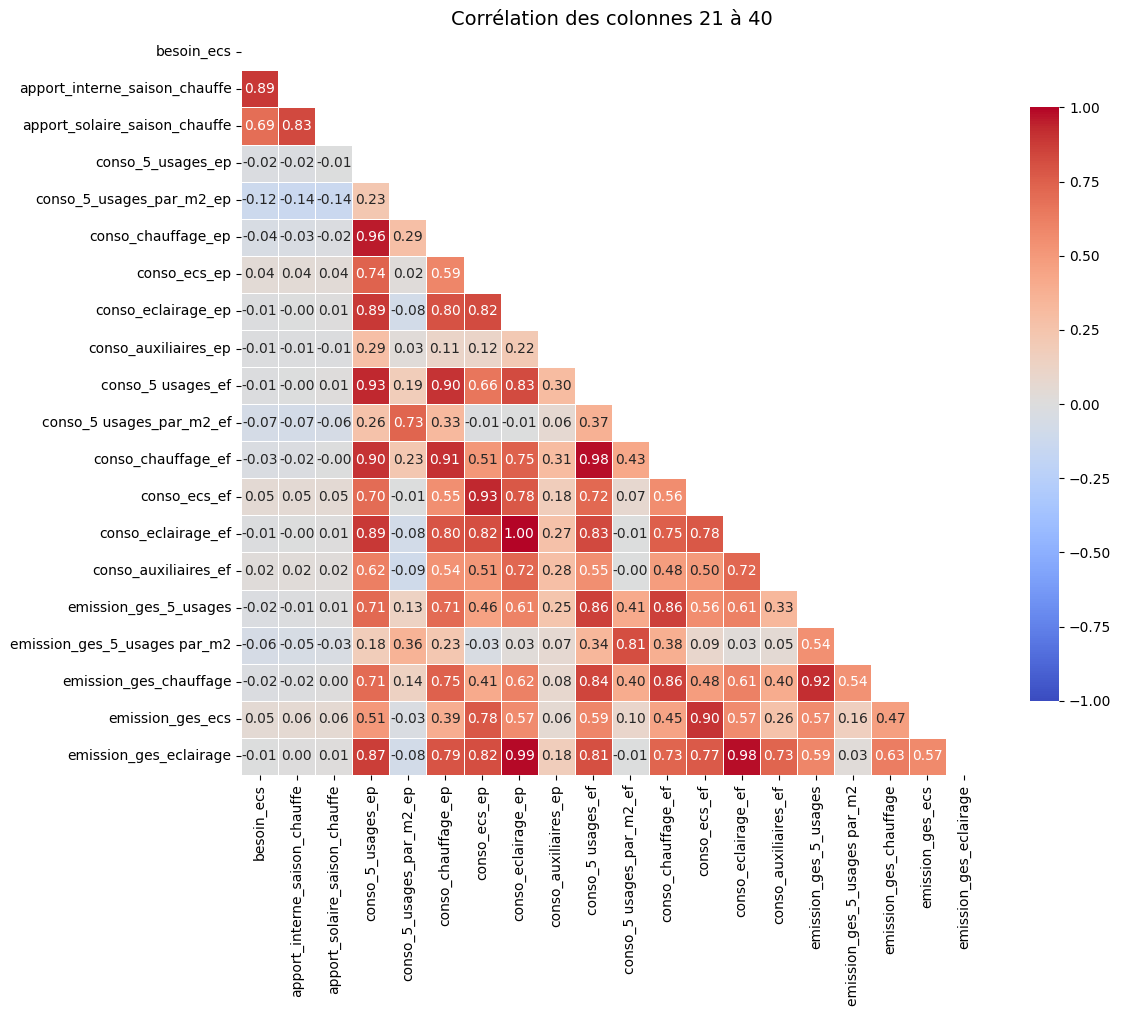

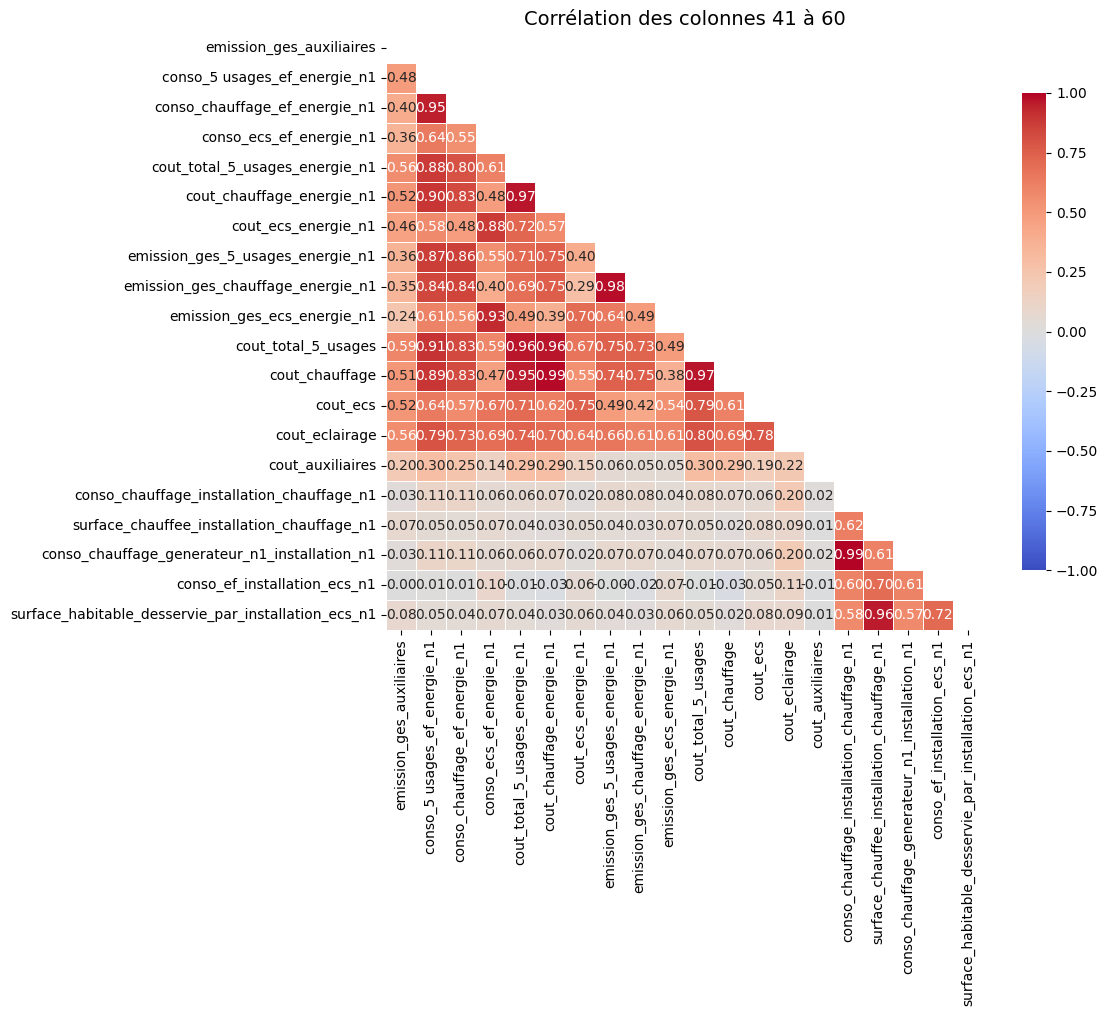

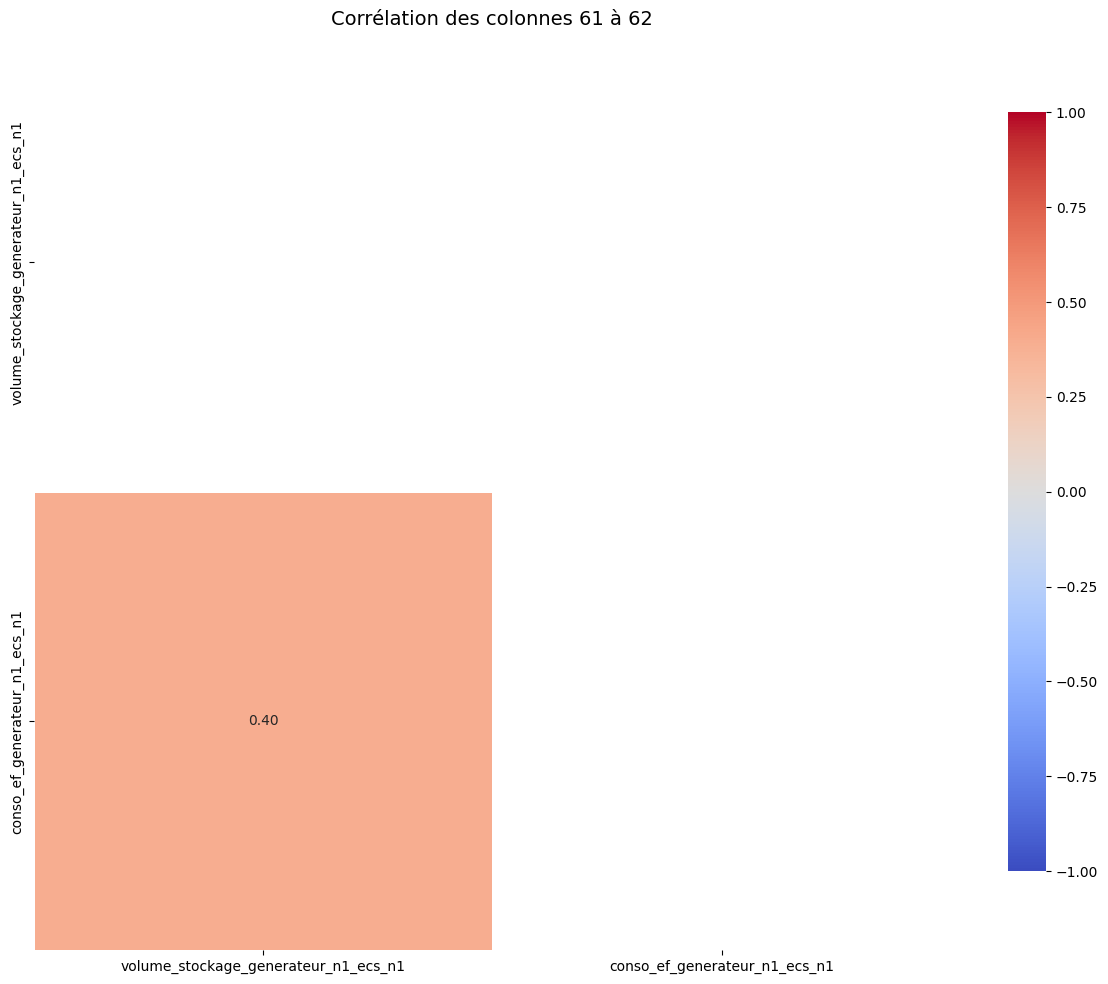

In [132]:


df = df_cleaned
# Calcul de la matrice de corrélation

# On récupère juste les variables numériques
num_df = df.select_dtypes(include='number')
cols = num_df.columns
n_cols = len(cols)

# Taille des blocs
block_size = 20

for start in range(0, n_cols, block_size):
    end = min(start + block_size, n_cols)
    block_cols = cols[start:end]

    corr_block = num_df[block_cols].corr()

    # Plot
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_block, dtype=bool))

    sns.heatmap(
        corr_block,
        mask=mask,
        cmap='coolwarm',
        vmax=1.0,
        vmin=-1.0,
        annot=True,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .8}
    )

    plt.title(f'Corrélation des colonnes {start+1} à {end}', fontsize=14)
    plt.tight_layout()
    plt.show()


La y'a que 61 colonnes quantitative donc ça nous montre 4 heatmaps. Quand on trouve 2 colonnes fortement corrélé ( +95% de corrélation, on peut en supprimer une des deux (celle avec le moins de NA)) Encore un fois c'est un des paramètre qu'on peut réduire et voir ensuite l'impacte sur le modèle

In [137]:
df = df_cleaned

num_df = df.select_dtypes(include='number')

# Matrice de corrélation absolue
corr_matrix = num_df.corr().abs()

# Extraire la partie supérieure de la matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les paires très corrélées (> 0.95)
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.95]
# Calcule du pourcentage de valeurs manquantes par colonne
na_ratio = df.isna().mean()

# Ajout des colonnes de NA pour chaque feature
high_corr_pairs["NA_Feature1"] = high_corr_pairs["Feature1"].map(na_ratio)
high_corr_pairs["NA_Feature2"] = high_corr_pairs["Feature2"].map(na_ratio)

# Trier par corrélation décroissante
high_corr_pairs_sorted = high_corr_pairs.sort_values(by="Correlation", ascending=False)

# Affichage propre
pd.set_option("display.max_rows", 100)  # augmente le nombre de lignes affichées
display(high_corr_pairs_sorted[["Feature1", "Feature2", "Correlation", "NA_Feature1", "NA_Feature2"]])


,Feature1,Feature2,Correlation,NA_Feature1,NA_Feature2
1887,conso_ef_installation_ecs_n1,conso_ef_generateur_n1_ecs_n1,1.000000,0.0116,0.0116
1301,conso_eclairage_ep,conso_eclairage_ef,0.997662,0.0000,0.0000
1601,emission_ges_chauffage,emission_ges_chauffage_energie_n1,0.995969,0.0000,0.0000
242,code_postal_ban,code_postal_brut,0.994855,0.0037,0.0000
1871,conso_chauffage_installation_chauffage_n1,conso_chauffage_generateur_n1_installation_n1,0.994778,0.0070,0.0070
1760,cout_chauffage_energie_n1,cout_chauffage,0.990622,0.0000,0.0000
1307,conso_eclairage_ep,emission_ges_eclairage,0.988425,0.0000,0.0000
1374,conso_5 usages_ef,conso_5 usages_ef_energie_n1,0.987977,0.0000,0.0000
1786,emission_ges_5_usages_energie_n1,emission_ges_chauffage_energie_n1,0.983057,0.0000,0.0000
209,surface_habitable_logement,conso_eclairage_ef,0.982983,0.0062,0.0000


In [133]:
# Supposons que df contient déjà les données nettoyées et numériques
df = df_cleaned

num_df = df.select_dtypes(include='number')

# Calculer la matrice de corrélation
corr_matrix = num_df.corr().abs()

# Pour éviter de re-check les mêmes paires, on met tout au-dessus de la diagonale à 0
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Liste des colonnes à supprimer
to_drop = []

for column in upper.columns:
    # On récupère les colonnes très corrélées avec celle-ci
    highly_corr = upper[column][upper[column] > 0.95].index.tolist()
    
    for other_col in highly_corr:
        na_column = df[column].isna().sum()
        na_other = df[other_col].isna().sum()

        # On garde celle qui a le moins de NA
        if na_column > na_other:
            to_drop.append(column)
        else:
            to_drop.append(other_col)

# Supprimer les doublons de la liste
to_drop = list(set(to_drop))

# Suppression
df_reduced = df.drop(columns=to_drop)

print(f"🔍 Colonnes supprimées car trop corrélées : {len(to_drop)}")
print("🗂️ Liste des colonnes supprimées :", to_drop)

🔍 Colonnes supprimées car trop corrélées : 20
🗂️ Liste des colonnes supprimées : ['code_postal_ban', 'conso_eclairage_ef', 'surface_habitable_logement', 'emission_ges_5_usages_energie_n1', 'conso_5 usages_ef_energie_n1', 'conso_eclairage_ep', 'cout_total_5_usages', 'deperditions_baies_vitrees', 'deperditions_renouvellement_air', 'surface_habitable_desservie_par_installation_ecs_n1', 'cout_chauffage_energie_n1', 'cout_total_5_usages_energie_n1', 'emission_ges_ecs', 'conso_chauffage_ef', 'conso_chauffage_installation_chauffage_n1', 'conso_ef_installation_ecs_n1', 'emission_ges_chauffage', 'deperditions_enveloppe', 'conso_5 usages_ef', 'conso_5_usages_ep']


Accuracy : 0.85

Classification Report :
               precision    recall  f1-score   support

           A       0.86      0.38      0.52        16
           B       0.72      0.28      0.40        47
           C       0.87      0.93      0.90       447
           D       0.87      0.94      0.90       622
           E       0.84      0.87      0.86       488
           F       0.82      0.69      0.75       245
           G       0.83      0.70      0.76       135

    accuracy                           0.85      2000
   macro avg       0.83      0.68      0.73      2000
weighted avg       0.85      0.85      0.85      2000



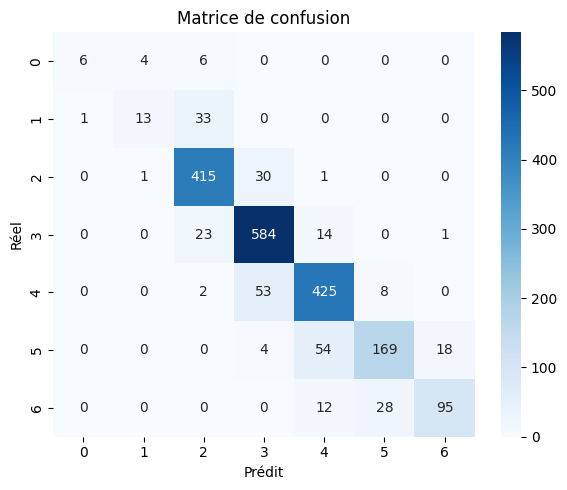

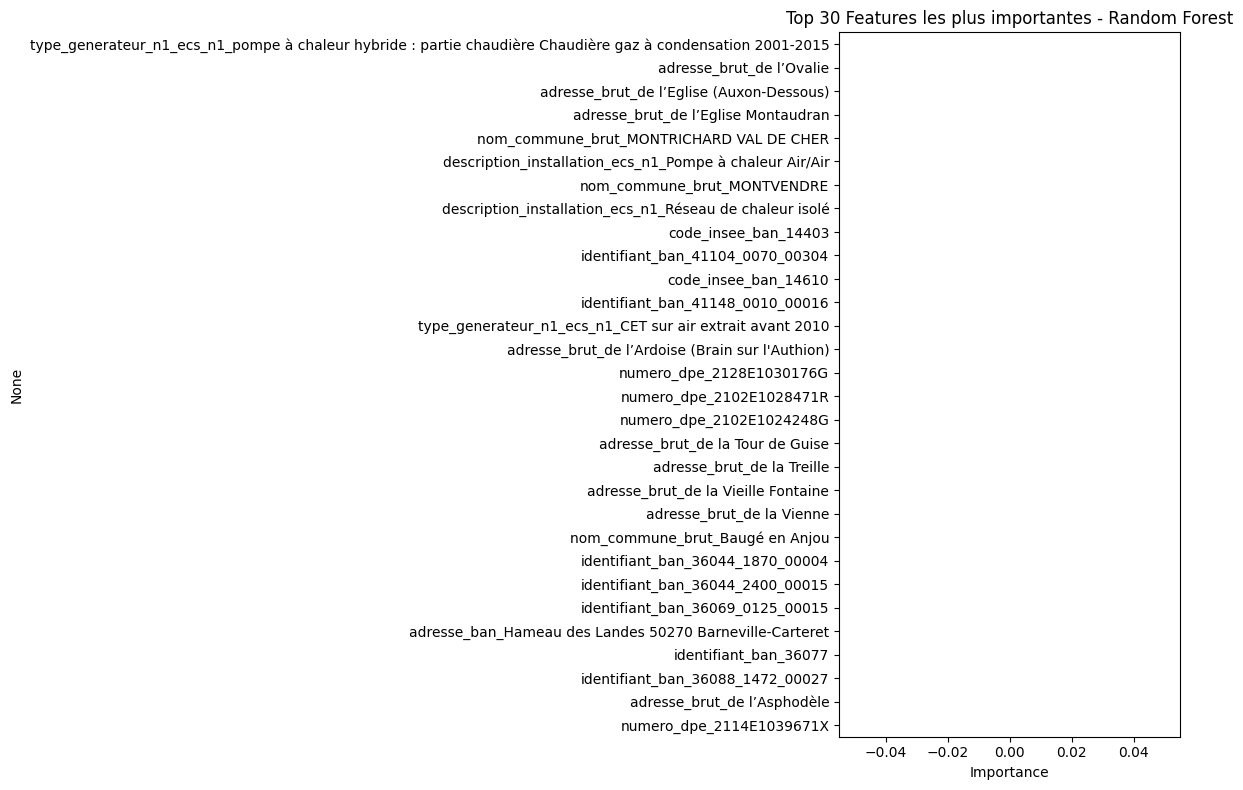

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
df = df_reduced

# 1. Identifier la cible et les features
target_col = 'etiquette_dpe'  # remplace par le nom de ta variable cible
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. Séparer qualitatives et quantitatives
qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
quantitative_cols = X.select_dtypes(include=['number']).columns

# 3. Encoder les variables qualitatives (one-hot)
X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy : {acc:.2f}")

# Rapport complet (précision, rappel, f1-score)
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# 6. Importance des features
importances = rf.feature_importances_
features = X_encoded.columns

# 7. Affichage
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:30], y=feature_importance.index[:30])  # top 30 features
plt.title("Top 30 Features les plus importantes - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Cross-Validation Accuracy: 0.87 ± 0.01

Test Accuracy : 0.85

Classification Report :
               precision    recall  f1-score   support

           A       0.86      0.38      0.52        16
           B       0.72      0.28      0.40        47
           C       0.87      0.93      0.90       447
           D       0.87      0.94      0.90       622
           E       0.84      0.87      0.86       488
           F       0.82      0.69      0.75       245
           G       0.83      0.70      0.76       135

    accuracy                           0.85      2000
   macro avg       0.83      0.68      0.73      2000
weighted avg       0.85      0.85      0.85      2000



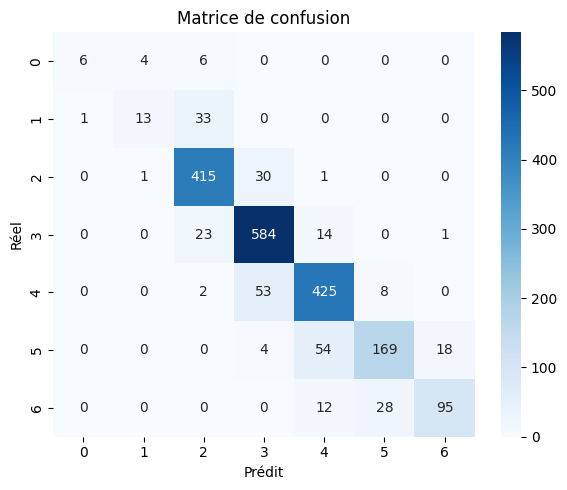

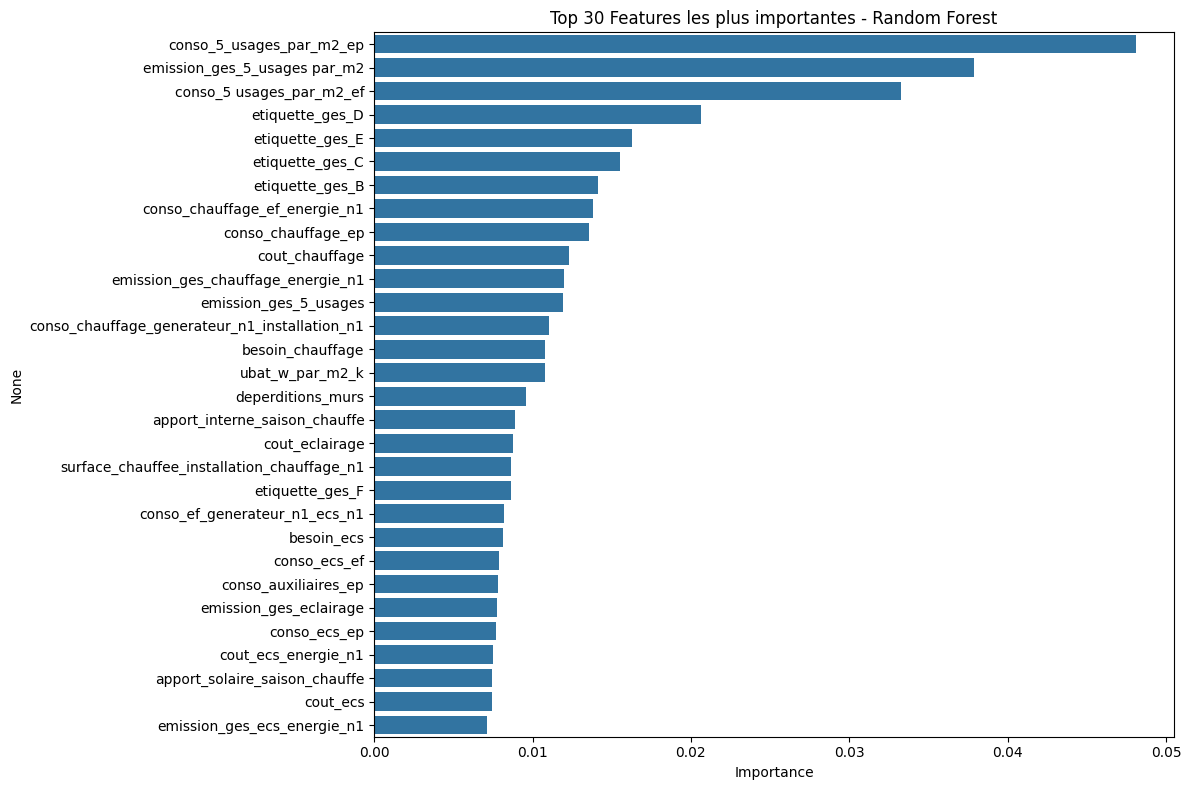

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppose que df_reduced est déjà défini
df = df_reduced

# 1. Identifier la cible et les features
target_col = 'etiquette_dpe'  # Remplace par le nom de ta variable cible
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. Séparer qualitatives et quantitatives
qualitative_cols = X.select_dtypes(include=['object', 'category']).columns
quantitative_cols = X.select_dtypes(include=['number']).columns

# 3. Encoder les variables qualitatives (one-hot)
X_encoded = pd.get_dummies(X, columns=qualitative_cols, drop_first=True)

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5 bis. Cross-validation
cv_scores = cross_val_score(rf, X_encoded, y, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Prédictions
y_pred = rf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy : {acc:.2f}")

# Rapport complet (précision, rappel, f1-score)
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# 6. Importance des features
importances = rf.feature_importances_
features = X_encoded.columns

# 7. Affichage
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:30], y=feature_importance.index[:30])  # top 30 features
plt.title("Top 30 Features les plus importantes - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


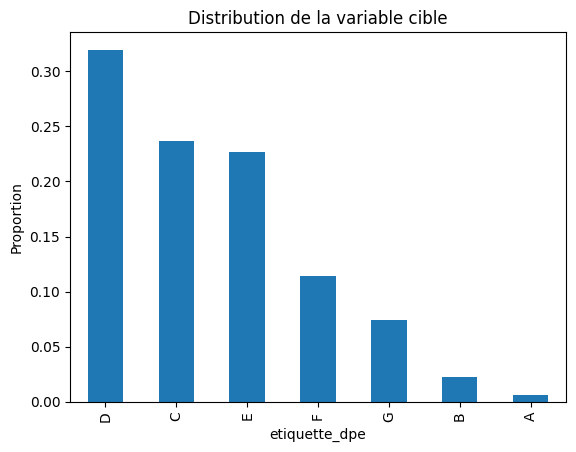

In [146]:
y.value_counts(normalize=True).plot(kind='bar', title="Distribution de la variable cible")
plt.ylabel("Proportion")
plt.show()


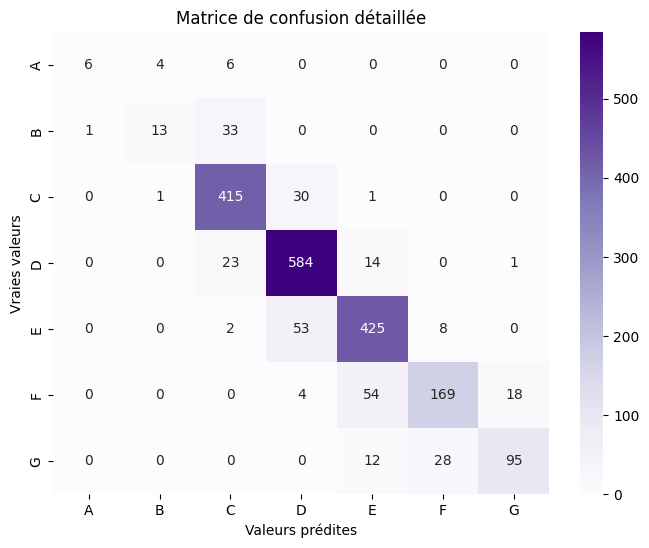

In [147]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_mat_df = pd.DataFrame(conf_mat, index=rf.classes_, columns=rf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Purples')
plt.title("Matrice de confusion détaillée")
plt.ylabel("Vraies valeurs")
plt.xlabel("Valeurs prédites")
plt.show()